# Question 2

## Q2.1
In this part, you will build a model to forecast the hourly carpark availability in the future
(aggregated across all carparks instead of looking at each carpark individually). Can you
explain why you may want to forecast the carpark availability in the future? Who would
find this information valuable? What can you do if you have a good forecasting model?

## A2.1
Nowadays, there are many developments and applications used to predict future outcomes. Examples include weather forecasting app which predicts weather conditions and allows users to plan their journey ahead. Another example will be predicting severity of an earthquake based on tremors on the early stages picked up by a seismic sensor which allows users to have ample time for evacuation.

Therefore, affirmed by the success that these systems have achieved, we want to predict furture carpark availability as this will be beneficial to different stakeholders. For example, vehicle owners will find it easier to plan their routes and schedule ahead of time. For event organiser, they can refer to the future carpark availabity and choose the best venue with high carpark availability for event organization. For carpark developers, they will be able to find out the potential spots with either high or low demand of car parks and thus, provide a better refinement to these carpark areas such as an expansion or reduction in size. 

With a good forecasting model, vehicle owners will be able to avoid the timings when there are severe traffic on the road and limited availability in the carpark areas. From a state planning perspective, organisations such as URA, LTA and HDB can make informed decisions guided by the forecasting model on the next course of action for a particular carpark. These course of action could be to expand/shrink the carpark's size, construction of another carpark near the current carpark or upgrading a particular carpark system to ensure smooth flow of cars in and out of the carpark.

## Q2.2 LR Model

### Data collection

In [33]:
import requests
import json
import pandas as pd
import datetime
from retry import retry
import time

In [ ]:
@retry(tries=3, delay=5)
def getDataAtTimestamp(year, month, day, hour, min_str='01', sec_str = '00'):
    try:
        site = f'https://api.data.gov.sg/v1/transport/carpark-availability?date_time={year}-{month.zfill(2)}-{day.zfill(2)}T{hour.zfill(2)}%3A{min_str.zfill(2)}%3A{sec_str.zfill(2)}'
        t1 = time.time()
        response_API = requests.get(site)
        t2 = time.time()
        response_API.encoding = 'UTF-8'
        raw_data = json.loads(response_API.content)
        t3 = time.time()
        print("req time = ", t2-t1, "json time = ", t3-t2)
        core_list = raw_data['items'][0]['carpark_data']
        return core_list
    except:
        raise Exception()

def json2csv(raw_data, year, month, day, hour, minute):
    header = ['timestamp', 'carpark_number', 'total_lots', 'lots_available', 'lot_type']
    res_df = pd.DataFrame(columns=header)
    timestamp = datetime.datetime(int(year), int(month),int(day))
    timestamp = timestamp.replace(hour=hour, minute=int(minute), second=0)
    for ele in raw_data:
        info = ele['carpark_info'][0]
        res_df = pd.concat([res_df, pd.DataFrame([[timestamp, ele['carpark_number'], info['total_lots'], info['lots_available'], info['lot_type']]], columns=header)])
        # res_df = res_df.append({'timestamp': timestamp, 'carpark_number': ele['carpark_number'], 'total_lots': info['total_lots'], 'lots_available': info['lots_available'], 'lot_type': info['lot_type']}, ignore_index=True)
    return res_df

In [ ]:
import threading
class Worker(threading.Thread):
    def __init__(self, year, month, day):
        super().__init__()
        self.year = year
        self.month = month
        self.day = day

    def run(self):
        raw_datalist = []
        minutes = ['00', "15", '30', '45']
        for hour in range(0, 24):
            print(f"start {self.year} {self.month} {self.day} {hour}")
            for mins in minutes:
                try:
                    raw_data = getDataAtTimestamp(self.year, self.month, self.day, str(hour), mins)
                except:
                    print("error in day: " + self.day + " hour: " + str(hour))
                    continue
                raw_df = json2csv(raw_data, self.year, self.month, self.day, hour, mins)
                raw_datalist.append(raw_df)
            print(f"done {self.year} {self.month} {self.day} {hour}")
        raw_datalist = pd.concat(raw_datalist)
        raw_datalist.to_csv(f'./data/{self.year}-{self.month}-{self.day}.csv', index=False)

In [ ]:
year = "2022"
month = "8"
workers = []
thread_count = 1
for rg in range(25, 26, thread_count):
    workers = []
    for day in range(rg, rg+thread_count):
        if day > 31:
            continue
        worker = Worker(year, month, str(day))
        worker.start()
        workers.append(worker)
    for worker in workers:
        worker.join()

start 2022 8 25 0
req time =  0.3698699474334717 json time =  2.09808349609375e-05
req time =  0.23649883270263672 json time =  4.887580871582031e-05
req time =  0.23379039764404297 json time =  2.288818359375e-05
error in day: 25 hour: 0
req time =  0.6727001667022705 json time =  0.0032067298889160156
req time =  1.0249099731445312 json time =  0.0038399696350097656
req time =  1.3583002090454102 json time =  0.006147861480712891
done 2022 8 25 0
start 2022 8 25 1
req time =  0.9791460037231445 json time =  0.00725102424621582
req time =  0.9909241199493408 json time =  0.006165027618408203
req time =  0.9117140769958496 json time =  0.003860950469970703
req time =  0.9819140434265137 json time =  0.007375955581665039
done 2022 8 25 1
start 2022 8 25 2
req time =  0.9968438148498535 json time =  0.006234169006347656
req time =  1.1588680744171143 json time =  0.006609201431274414
req time =  1.0754339694976807 json time =  0.002620220184326172
req time =  1.1069660186767578 json time

### Data cleaning

In [3]:
def load_data(month):
    full_df = pd.read_csv(f"./data/2022-{str(month)}-1.csv")
    for date in range(2, 32):
        test_df = pd.read_csv(f'./data/2022-{str(month)}-{date}.csv')
        full_df = pd.concat([full_df, test_df])
    print(full_df.shape)
    full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])
    full_df = full_df.set_index('timestamp')
    return full_df
jul = load_data(7)
aug = load_data(8)

(5785166, 5)
(5781908, 5)


In [4]:
rg_jul = pd.Series(pd.date_range(
    '7/1/2022', '8/1/2022', freq='1h', inclusive='left'))
rg_aug = pd.Series(pd.date_range(
    '8/1/2022', '9/1/2022', freq='1h', inclusive='left'))
jul = jul.resample('1h').mean()
jul['available rate'] = jul['lots_available'] / jul['total_lots']

aug = aug.resample('1h').mean()
aug['available rate'] = aug['lots_available'] / aug['total_lots']
print(jul.shape, aug.shape)

display(jul)
display(aug)

(744, 3) (744, 3)


,total_lots,lots_available,available rate
timestamp,,,
2022-07-01 00:00:00,367.245899,172.771013,0.470450
2022-07-01 01:00:00,367.664210,170.280269,0.463141
2022-07-01 02:00:00,367.687127,168.249206,0.457588
2022-07-01 03:00:00,367.795729,168.253845,0.457465
2022-07-01 04:00:00,367.928644,168.423048,0.457760
...,...,...,...
2022-07-31 19:00:00,367.645444,201.401703,0.547815
2022-07-31 20:00:00,367.824689,197.226672,0.536197
2022-07-31 21:00:00,367.562063,191.428789,0.520807


,total_lots,lots_available,available rate
timestamp,,,
2022-08-01 00:00:00,367.477900,174.520406,0.474914
2022-08-01 01:00:00,367.081822,172.206901,0.469124
2022-08-01 02:00:00,367.718663,170.935164,0.464853
2022-08-01 03:00:00,367.770121,170.147997,0.462648
2022-08-01 04:00:00,367.957285,169.941012,0.461850
...,...,...,...
2022-08-31 19:00:00,366.995556,217.564063,0.592825
2022-08-31 20:00:00,366.957471,203.848292,0.555509
2022-08-31 21:00:00,367.173377,195.556713,0.532600


### LR model

In [5]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

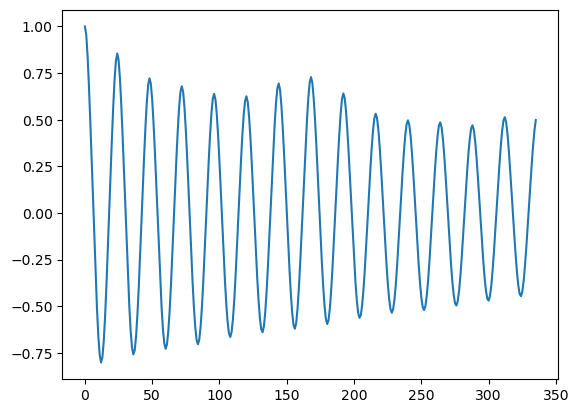

In [6]:
lags = range(24*7*2)
acorr = sm.tsa.acf(jul['available rate'], nlags = len(lags)-1)
plt.plot(lags, acorr)

We plot the auto correlation of the availability with lag from 0-14 days. We find that there is a stronger auto correlation with the  availability with 1 day lag or roughly 7 days lags. Thus, we use the availability in the previous 8 days as input features to predict the availability in the next hour.

In [7]:
def prep_train_test(dataset, feature_len):
    X = []
    Y = []
    for i in range(feature_len, len(dataset)):
        X.append(dataset['available rate'][i-feature_len:i].values)
        Y.append(dataset['available rate'][i])
    X = np.array(X)
    Y = np.array(Y)
    print(X.shape, Y.shape)
    return X, Y

In [8]:
"""
Build two models using different features
model1: use the last week's data
model2: use the last days data
"""
feature_len1 = 24*8
X_train1, Y_train1 = prep_train_test(jul, feature_len1)
X_test1, Y_test1 = prep_train_test(aug, feature_len1)

# feature_len2 = 24
# X_train2, Y_train2 = prep_train_test(jul, feature_len2)
# X_test2, Y_test2 = prep_train_test(aug, feature_len2)

(552, 192) (552,)
(552, 192) (552,)


In [9]:
model1 = LinearRegression()
model1.fit(X_train1, Y_train1)
preds1 = model1.predict(X_test1)

# model2 = LinearRegression()
# model2.fit(X_train2, Y_train2)
# preds2 = model2.predict(X_test2)

### Evaluting two LR model performance

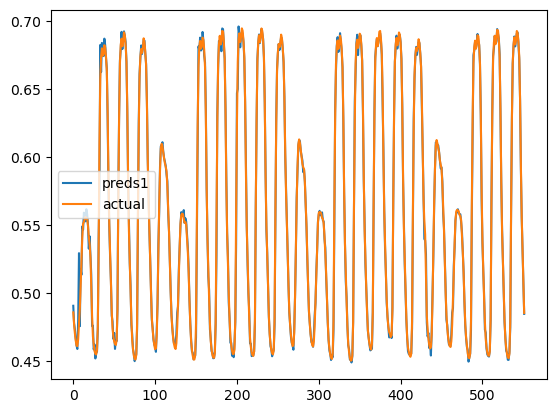

In [10]:
plt.plot(preds1, label='preds1')
# plt.plot(preds2[-len(preds1):], label='preds2')
plt.plot(Y_test1, label='actual')
plt.legend()

Text(0, 0.5, 'Actual')

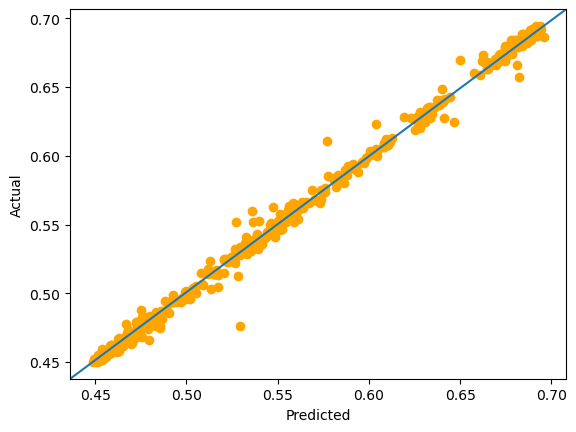

In [11]:
plt.scatter(preds1, Y_test1, label='preds1', color='orange')
# plt.scatter(preds2, Y_test2, label='preds2')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)

In [12]:
m1_r2score = model1.score(X_test1, Y_test1)
lr_rms = np.sqrt(np.mean(np.power((np.array(Y_test1)-np.array(preds1)),2)))
lr_percentage_err = np.mean(np.abs((np.array(Y_test1)-np.array(preds1))/np.array(Y_test1)))*100
print(f"model's r2score: {m1_r2score},\nrms: {lr_rms},\npercentage_err: {lr_percentage_err}")


# rms = mean_squared_error(Y_test1, preds1, squared=False)
# r2Score = r2_score(Y_test1, preds1)
# percentageError = mean_absolute_percentage_error(Y_test1, preds1)
# print(f"model's r2score: {r2Score},\nrms: {rms},\npercentage_err: {percentageError}")

model's r2score: 0.9966407757695142,
rms: 0.0050174958828139,
percentage_err: 0.5211824132081798


<AxesSubplot:>

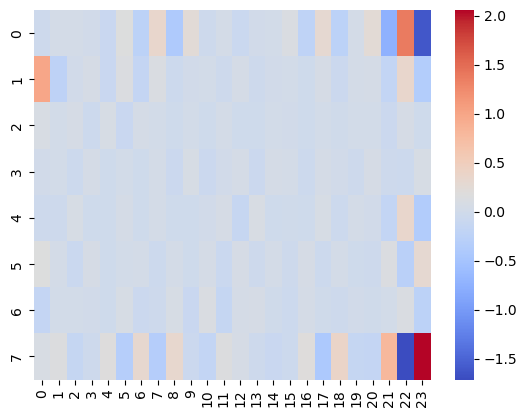

In [13]:
weights = model1.coef_
sns.heatmap(weights.reshape(8,-1), cmap='coolwarm')

Since the model has a very high r2 score, it means that the output's variance can be very well explained by the variance in the input features. <br>
The percentage error is 0.5%, which means that the predicted availability is very close to the actual availability. <br>
Looking at the relative importance of all features, we find that there is a strong correlation between the availability few hours ago, 1 day ago and 1 week ago, this corroborates with our initial assumption. <br>
From the scatter plot, we can see that the points are all very close to the line y=x, which means that the predicted availability is very close to the actual availability.<br>
Thus based on above evidence, the model is very good.

## Q2.3 SVR Model
Repeat this for Support Vector Regressor

In [21]:
feature_len1 = 24*8
X_train1, Y_train1 = prep_train_test(jul, feature_len1)
X_test1, Y_test1 = prep_train_test(aug, feature_len1)

(552, 192) (552,)
(552, 192) (552,)


In [27]:
from sklearn.svm import SVR

linear_SVM = SVR(degree=3, C=100, epsilon=.01)
# Train for July
linear_SVM.fit(X_train1, Y_train1)
# Predict for Aug
y_pred_SVR = linear_SVM.predict(X_test1) 

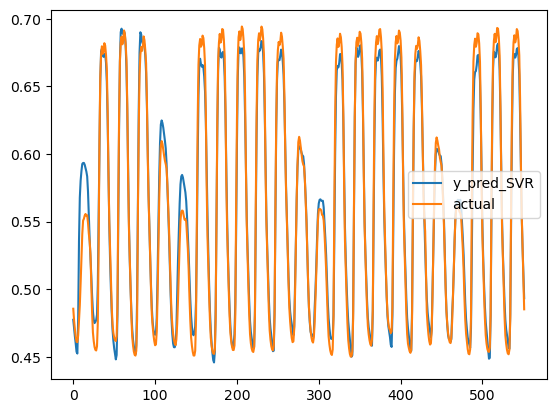

In [28]:
plt.plot(y_pred_SVR, label='y_pred_SVR')
plt.plot(Y_test1, label='actual')
plt.legend()

# print(f"min of y_pred is {min(y_pred_SVR)} max of y_pred is {max(y_pred_SVR)} ")
# print(f"min of Y_test1 is {min(Y_test1)} max of Y_test1 is {max(Y_test1)} ")
# print(f"min of Y_train1 is {min(Y_train1)} max of Y_train1 is {max(Y_train1)} ")

Text(0, 0.5, 'Actual')

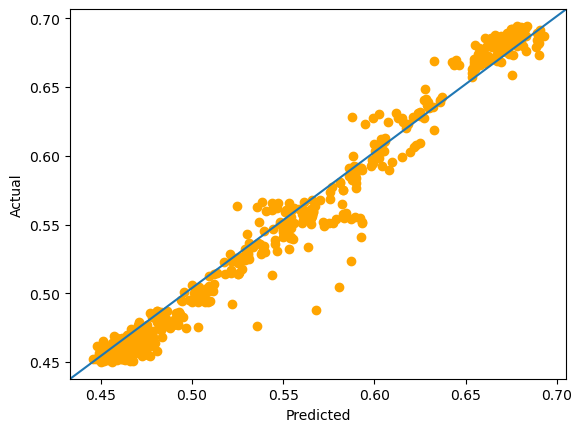

In [29]:
plt.scatter(y_pred_SVR, Y_test1, label='y_pred_SVR', color='orange')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)

In [13]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

svm_rms = mean_squared_error(Y_test1, y_pred_SVR, squared=False)
M2_r2Score = r2_score(Y_test1, y_pred_SVR)
svm_percentageError = mean_absolute_percentage_error(Y_test1, y_pred_SVR)
print(f"Model's r2score: {M2_r2Score},\nRMS: {svm_rms},\nPercentage Error: {svm_percentageError*100} %")

Model's r2score: 0.976496190645292,
RMS: 0.013272008634431079,
Percentage Error: 1.743433383019374 %


### Intepretation of model's performance
The SVR model has a very high R Square value of 0.976 which indicates a good fit between predicted and actual value.

The percentage error at 1.75% means that the predicted values are very close to the actual values.

From these metrics, it can be seen that SVR is a fairly good model for this data distribution.

## Q2.4 DT Model

In [25]:
feature_len1 = 24*8
X_train1, Y_train1 = prep_train_test(jul, feature_len1)
X_test1, Y_test1 = prep_train_test(aug, feature_len1)
# feature_len2 = 24
# X_train2, Y_train2 = prep_train_test(jul, feature_len2)
# X_test2, Y_test2 = prep_train_test(aug, feature_len2)

(552, 192) (552,)
(552, 192) (552,)


In [26]:
# import the regressor
from sklearn.tree import DecisionTreeRegressor
  
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train1, Y_train1)
pred_dt = regressor.predict(X_test1)
# regressor.fit(X_train2, Y_train2)
# pred_dt2 = regressor.predict(X_test2)

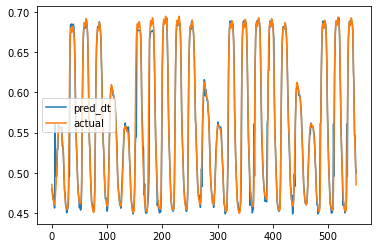

In [27]:
plt.plot(pred_dt, label='pred_dt')
plt.plot(Y_test1, label='actual')
plt.legend()

Text(0, 0.5, 'Actual')

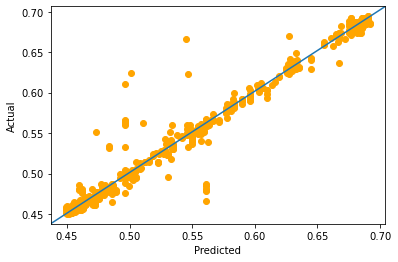

In [28]:
plt.scatter(pred_dt, Y_test1, label='pred_dt', color='orange')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes)
plt.xlabel('Predicted', fontsize=10)
plt.ylabel('Actual', fontsize=10)

In [70]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

dt_rms = mean_squared_error(Y_test1, pred_dt, squared=False)
m3_r2Score = r2_score(Y_test1, pred_dt)
dt_percentageError = mean_absolute_percentage_error(Y_test1, pred_dt)
print(f"Model's r2score: {m3_r2Score},\nRMS: {dt_rms},\nPercentage Error: {dt_percentageError*100} %")

# rms = mean_squared_error(Y_test1, pred_dt, squared=False)
# r2Score = r2_score(Y_test2, pred_dt2)
# percentageError = mean_absolute_percentage_error(Y_test2, pred_dt2)
# print(f"Model's r2score: {r2Score},\nRMS: {rms},\nPercentage Error: {percentageError*100}%")

Model's r2score: 0.9649422172971697,
RMS: 0.016209131667976325,
Percentage Error: 1.2708128175207298 %


The Decision Tree Regressor model has a r2 score of 0.9649 which is very closed 1. This indicates that the availability in the previous 1 week and the availability in the next hour are strongly correlated, i.e., with small variance.
The small RMS value indicates that the difference between the predicted values and the actual values is small. 
Given sufficient amount of data, a percentage error of 1.27% proves that the model is able to forecast values well.
Thus, decision tree regressor is also a good model for this data distribution.

## Q2.5 Final recommendation 

Before we make a final recommendation for the final regression model, we first use hyperparameter tuning to refine the result obtained from the three model by trial and error. For linear regression, there is no any hyperparameter for tuning. Thus, we only tune the hyperparameters for SVM and DT model.The performance of the three models before hyperparameter tuning is shown below

In [88]:
pd_list = np.array([[m1_r2score,M2_r2Score,m3_r2Score],[lr_rms,svm_rms,dt_rms],[lr_percentage_err,svm_percentageError*100,dt_percentageError*100]])
df = pd.DataFrame(pd_list.transpose(), index = ['LR', 'SVM', 'DT'], columns = ['r2score', 'RMS', 'Percentage_error'])
df

,r2score,RMS,Percentage_error
LR,0.996641,0.005017,0.521182
SVM,0.976496,0.013272,1.743433
DT,0.964942,0.016209,1.270813


Next, we modify the SVM by changing the C value to 10 where C is the regularization parameter. A small value of C can lead to an increase in regularization strength. The result is obtained below.

In [90]:
linear_SVM = SVR(kernel = 'linear', C=10, epsilon=.01)
# Train for July
linear_SVM.fit(X_train1, Y_train1)
# Predict for Aug
y_pred_SVR = linear_SVM.predict(X_test1) 

svm_rms_new = mean_squared_error(Y_test1, y_pred_SVR, squared=False)
M2_r2Score_new = r2_score(Y_test1, y_pred_SVR)
svm_percentageError_new = mean_absolute_percentage_error(Y_test1, y_pred_SVR)
print(f"Model's r2score: {M2_r2Score_new},\nRMS: {svm_rms_new},\nPercentage Error: {svm_percentageError_new*100} %")


Model's r2score: 0.9866071934334709,
RMS: 0.010018514378717333,
Percentage Error: 1.4156058866506924 %


We also modify the DT by limiting the maximum depth to 10.

In [91]:
# create a regressor object
regressor = DecisionTreeRegressor(max_depth = 10, random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train1, Y_train1)
pred_dt = regressor.predict(X_test1)

dt_rms_new = mean_squared_error(Y_test1, pred_dt, squared=False)
m3_r2Score_new = r2_score(Y_test1, pred_dt)
dt_percentageError_new = mean_absolute_percentage_error(Y_test1, pred_dt)
print(f"Model's r2score: {m3_r2Score_new},\nRMS: {dt_rms_new},\nPercentage Error: {dt_percentageError_new*100} %")

Model's r2score: 0.9807883278333591,
RMS: 0.011999139743660745,
Percentage Error: 0.9946445103512334 %


After hyperparameter tuning, the new performance result is shown below.

In [93]:
pd_list = np.array([[m1_r2score,M2_r2Score_new,m3_r2Score_new],[lr_rms,svm_rms_new,dt_rms_new],[lr_percentage_err,svm_percentageError_new*100,dt_percentageError_new*100]])
df = pd.DataFrame(pd_list.transpose(), index = ['LR', 'SVM', 'DT'], columns = ['r2score', 'RMS', 'Percentage_error'])
df

,r2score,RMS,Percentage_error
LR,0.996641,0.005017,0.521182
SVM,0.986607,0.010019,1.415606
DT,0.980788,0.011999,0.994645


## Conclusion
To evaluate these three models, we select r2score, root-mean-square error and percentage error as key performance metrics. From the table shown above, the linear regression generally outperforms other two models in terms of all three performance metrics. Therefore, in terms of quantitative evulation, linear regression is the best model to be used for our data. Furthermore, in terms of qualitative arguments, the biggest advantage of linear regression is linearity. As we can see in the previous part, the feature and the label have a very strong correlation and there are few outliers (less noise), which makes linear regression a better choice. Additionally, linear regression model makes the estimation procedure simple and it is easy to interpret the output coefficients. With less complexity as compared to other models, we can conclude that linear regression is the best regression model for this data distribution.